<a href="https://colab.research.google.com/github/bluepsm/recommendation-system/blob/main/recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation System

**Objective:** Build a recommendation system for products, movies, etc.

**Skills:** Collaborative filtering, content-based filtering, hybrid methods, matrix factorization, evaluation metrics for recommendation systems.

In [3]:
#@title Import Library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

!pip install scikit-surprise
from surprise import Dataset, Reader, SVD, SVDpp, SlopeOne, KNNBaseline, KNNWithMeans, BaselineOnly, accuracy
from surprise.model_selection import GridSearchCV, cross_validate

In [4]:
#@title Import Dataset

missing_values = ['na', '--', '?', '-', 'None', 'none', 'non']

ratings_df = pd.read_csv('/content/drive/MyDrive/datasets/movie-lens-20m/rating.csv', na_values=missing_values)
movies_df = pd.read_csv('/content/drive/MyDrive/datasets/movie-lens-20m/movie.csv', na_values=missing_values)

In [5]:
#@title Data Prepocessing

# Using regular expressions to find a year stored between parentheses
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)', expand=False)

# Removing the parentheses from the 'year' column
movies_df['year'] = movies_df['year'].str.extract(r'(\d{4})', expand=False)

# Filling year NaN values with zeros.
movies_df['year'].fillna(0, inplace=True)

# Converting columns year from obj to int16
movies_df['year'] = movies_df['year'].astype('int16')

# Removing the years from the 'title' column
movies_df['title'] = movies_df['title'].str.replace(r'\(\d{4}\)', '', regex=True)

# Applying the strip function to get rid of any leading or trailing whitespace characters
movies_df['title'] = movies_df['title'].str.strip()

# Split genres into list
movies_df['genres'] = movies_df['genres'].str.split('|')

# Converting columns userId and movieId from int64 to int32 to save memory.
ratings_df['userId'] = ratings_df['userId'].astype('int32')
ratings_df['movieId'] = ratings_df['movieId'].astype('int32')
movies_df['movieId'] = movies_df['movieId'].astype('int32')

# Converting columns rating from float64 to float16 to save memory
ratings_df['rating'] = ratings_df['rating'].astype('float16')

# Dropping timestamp column
ratings_df.drop('timestamp', axis=1, inplace=True)

In [6]:
#@title One-Hot encoding

# Create a copy of the original DataFrame
movies_df_backup = movies_df.copy()

# Explode the 'genres' column to create a row for each genre per movie
movies_exploded = movies_df.explode('genres')

# Create dummy variables for the exploded genres
genres_dummies = pd.get_dummies(movies_exploded['genres'])

# Group the dummy variables back to movie level, aggregating with max (presence of genre is enough)
genres_dummies = genres_dummies.groupby(movies_exploded['movieId']).max()

# Merge the dummy variables back to the original DataFrame
movies_df = pd.merge(movies_df, genres_dummies, left_on='movieId', right_index=True, how='left')
movies_df.drop('genres', axis=1, inplace=True)

movies_df.head()

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji,1995,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men,1995,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale,1995,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II,1995,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [7]:
#@title Create Movies Dataframe With Only Genre

movies_genres_df = movies_df.copy()

movies_genres_df.set_index('movieId', inplace=True)
movies_genres_df.drop(['title', 'year'], axis=1, inplace=True)

In [8]:
#@title Merging Movies and Rating Dataframe

# movies_ratings_df = pd.merge(ratings_df, movies_df, on='movieId')
movies_ratings_df = pd.merge(ratings_df, movies_df, on='movieId').iloc[:5000000, :]

movies_ratings_df.head()

,userId,movieId,rating,title,year,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,2,3.5,Jumanji,1995,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
1,5,2,3.0,Jumanji,1995,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
2,13,2,3.0,Jumanji,1995,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
3,29,2,3.0,Jumanji,1995,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
4,34,2,3.0,Jumanji,1995,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


In [9]:
#@title Load Data to Surprise Dataset Object

reader = Reader(rating_scale=(0.5, 5))

train_dataset = Dataset.load_from_df(movies_ratings_df[['userId', 'movieId', 'rating']], reader)

trainset = train_dataset.build_full_trainset()

In [10]:
#@title Load MovieLens 100k For Benchmarking

# movielens_100k = Dataset.load_builtin('ml-100k')

In [11]:
#@title User Profile For Testing

user_count = {}
for user_id in movies_ratings_df['userId']:
  if user_id in user_count:
    user_count[user_id] += 1
  else:
    user_count[user_id] = 1

user_more_than_10 = []
for user_id, count in user_count.items():
  if count > 10:
    user_more_than_10.append(user_id)

random_userId = random.choice(user_more_than_10)

print('User ID: ', random_userId)
print('Number of movies rated: ', len(movies_ratings_df.loc[movies_ratings_df['userId'] == random_userId]))

User ID:  88584
Number of movies rated:  139


# Collaborative Filtering

In [12]:
#@title Model Benchmark

# benchmark = []

# for algorithm in [SVD(), SVDpp(), SlopeOne(), KNNBaseline(), KNNWithMeans(), BaselineOnly()]:
#   results = cross_validate(algorithm, movielens_100k, measures=['RMSE'], cv=3, verbose=False)
#   tmp = pd.DataFrame.from_dict(results).mean(axis=0)
#   tmp = pd.concat([tmp, pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm'])])
#   benchmark.append(tmp)

# pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

## SVD

In [13]:
#@title Find Optimal Parameters

# svd_param_gs = {
#     'n_epochs': [30, 35, 40],
#     'lr_all': [0.003, 0.01, 0.02],
#     'reg_all': [0.1, 0.2, 0.3]
# }

# svd_gs = GridSearchCV(SVD, svd_param_gs, measures=['rmse'], cv=3)
# svd_gs.fit(movielens_100k)

In [14]:
#@title Best Parameters

# print(svd_gs.best_score['rmse'])
# print(svd_gs.best_params['rmse'])

In [15]:
#@title Building Algorithm

svd_param = {
    'n_epochs': 35,
    'lr_all': 0.01,
    'reg_all': 0.1,
}

svd_algorithm = SVD(**svd_param)

In [16]:
#@title Training Algorithm

svd_algorithm.fit(trainset)

In [17]:
#@title Algorithm Testing

testset = trainset.build_testset()

svd_predictions = svd_algorithm.test(testset)
accuracy.rmse(svd_predictions)

RMSE: 0.8011


0.8010576458564017

### Evaluate

In [18]:
#@title Sorting Best and Worst Predictions

def get_Iu(uid):
  """ return the number of items rated by given user
  args:
    uid: the id of the user
  returns:
    the number of items rated by the user
  """
  try:
    return len(trainset.ur[trainset.to_inner_uid(uid)])
  except ValueError: # user was not part of the trainset
    return 0

def get_Ui(iid):
  """ return number of users that have rated given item
  args:
    iid: the raw id of the item
  returns:
    the number of users that have rated the item.
  """
  try:
    return len(trainset.ir[trainset.to_inner_iid(iid)])
  except ValueError:
    return 0

svd_predictions_df = pd.DataFrame(svd_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
svd_predictions_df['Iu'] = svd_predictions_df.uid.apply(get_Iu)
svd_predictions_df['Ui'] = svd_predictions_df.iid.apply(get_Ui)
svd_predictions_df['err'] = abs(svd_predictions_df.est - svd_predictions_df.rui)
best_svd_predictions = svd_predictions_df.sort_values(by='err', ascending=True)
best_svd_predictions.drop_duplicates(subset=['iid'], keep='first', inplace=True)
worst_svd_predictions = svd_predictions_df.sort_values(by='err', ascending=False)
worst_svd_predictions.drop_duplicates(subset=['iid'], keep='first', inplace=True)

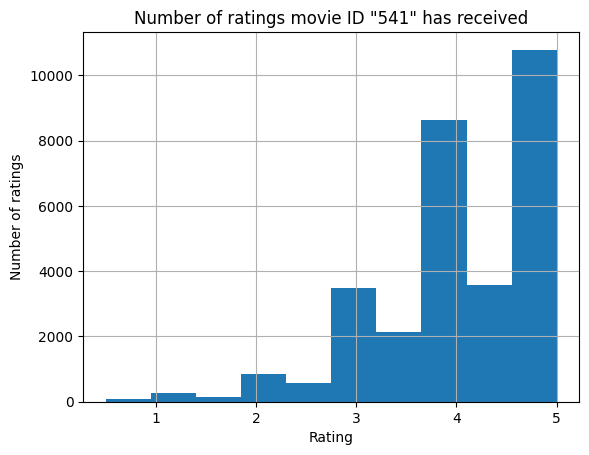

In [19]:
#@title Inspecting Best Predictions

best_svd_predictions.head(10)

movies_ratings_df.loc[movies_ratings_df['movieId'] == 541]

movies_ratings_df.loc[movies_ratings_df['movieId'] == 541]['rating'].hist()
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings movie ID "541" has received')
plt.show();

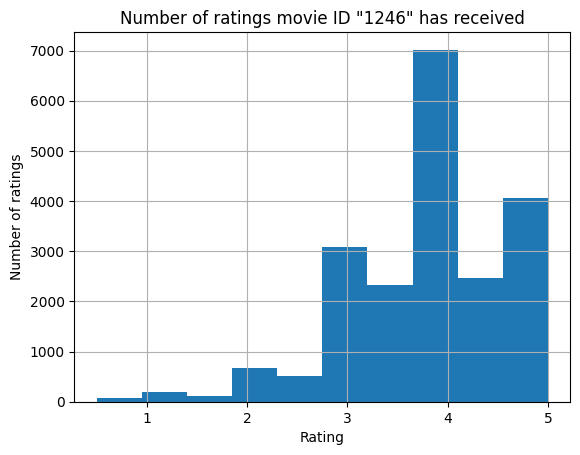

In [20]:
#@title Inspecting Worst

worst_svd_predictions.head(10)

movies_ratings_df.loc[movies_ratings_df['movieId'] == 1246]

movies_ratings_df.loc[movies_ratings_df['movieId'] == 1246]['rating'].hist()
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings movie ID "1246" has received')
plt.show();

### Predictions

In [21]:
#@title Define Collaborative Filtering Function

def get_collaborative_filtering_recommendations(userId, top_n):
  user_testset = trainset.build_anti_testset()
  user_testset = filter(lambda x: x[0] == userId, user_testset)

  pred = svd_algorithm.test(user_testset)
  pred.sort(key=lambda x: x.est, reverse=True)
  collaborative_recommendations = [pred.iid for pred in pred[:top_n]]

  return collaborative_recommendations

In [22]:
#@title Predict User Ratings

collaborative_recommendations = get_collaborative_filtering_recommendations(random_userId, 20)

collaborative_recommendations

[3030,
 905,
 1307,
 1217,
 858,
 1262,
 1228,
 2028,
 1222,
 1246,
 3000,
 3265,
 6539,
 953,
 1199,
 29,
 1348,
 8368,
 3037,
 1090]

# Content-based Filtering

In [23]:
#@title Define Content-based Filtering Function

def get_user_preferences(userId):
  user_movie_ratings_df = movies_ratings_df.loc[movies_ratings_df['userId'] == userId]

  # user_movie_ratings_df = user_movie_ratings_df[['userId', 'movieId', 'rating']]
  user_movie_ratings_df = user_movie_ratings_df[['movieId', 'title', 'rating']]

  user_movie_ratings_df.reset_index(inplace=True, drop=True)

  # filter the selection by outputing movies that exist in both user_movie_ratings_df and movies_df.
  user_movie_genres_df = movies_df[movies_df.movieId.isin(user_movie_ratings_df.movieId)].copy()

  # Reset index to default and drop the existing index.
  user_movie_genres_df.reset_index(drop=True, inplace=True)

  # Drop redundant columns
  user_movie_genres_df.drop(['movieId', 'title', 'year'], axis=1, inplace=True)

  # Find the dot product of transpose of user_movie_genres_df by user rating column.
  user_preferences = user_movie_genres_df.T.dot(user_movie_ratings_df.rating)

  return user_preferences


def get_content_based_recommendations(userId, top_n):
  user_preferences = get_user_preferences(userId)

  # Multiply the genres by the weights and then take the weighted average.
  content_based_recommendations = (movies_genres_df.dot(user_preferences)) / user_preferences.sum()

  content_based_recommendations = content_based_recommendations.sort_values(ascending=False).head(top_n)
  content_based_recommendations = content_based_recommendations.index.tolist()

  return content_based_recommendations

In [24]:
#@title Find Similarity Movies

content_based_recommendations = get_content_based_recommendations(random_userId, 20)

content_based_recommendations

[81132,
 5018,
 71999,
 83266,
 115479,
 122787,
 6902,
 117646,
 4956,
 75408,
 76153,
 43932,
 49593,
 116758,
 27032,
 8361,
 91500,
 48774,
 27618,
 58025]

# Hybrid Filtering

In [25]:
#@title Define Hybrid Filtering Function

def get_hybrid_recommendations(user_id, top_n):
  content_based_recommendations = get_content_based_recommendations(user_id, top_n)
  collaborative_recommendations = get_collaborative_filtering_recommendations(user_id, top_n)
  hybrid_recommendations = list(set(content_based_recommendations + collaborative_recommendations))
  return hybrid_recommendations[:top_n]

In [27]:
#@title Recommend Movies to User

hybrid_recommendations = get_hybrid_recommendations(random_userId, 20)

hybrid_recommendations_df = movies_df_backup.loc[movies_df_backup['movieId'].isin(hybrid_recommendations)]

hybrid_recommendations_df

,movieId,title,genres,year
28,29,"City of Lost Children, The (Cité des enfants p...","[Adventure, Drama, Fantasy, Mystery, Sci-Fi]",1995
888,905,It Happened One Night,"[Comedy, Romance]",1934
936,953,It's a Wonderful Life,"[Drama, Fantasy, Romance]",1946
1174,1199,Brazil,"[Fantasy, Sci-Fi]",1985
1278,1307,When Harry Met Sally...,"[Comedy, Romance]",1989
2914,3000,Princess Mononoke (Mononoke-hime),"[Action, Adventure, Animation, Drama, Fantasy]",1997
4922,5018,Motorama,"[Adventure, Comedy, Crime, Drama, Fantasy, Mys...",1991
6429,6539,Pirates of the Caribbean: The Curse of the Bla...,"[Action, Adventure, Comedy, Fantasy]",2003
7762,8361,"Day After Tomorrow, The","[Action, Adventure, Drama, Sci-Fi, Thriller]",2004
7769,8368,Harry Potter and the Prisoner of Azkaban,"[Adventure, Fantasy, IMAX]",2004
